# Split-step Fourier beam propagation method (SSF-BPM)

For nonlinear propagation in linear or chi-3 media, according to the nonlinear Schrodinger equation (NLSE).



In [ ]:
from google.colab import drive
from scipy.signal import convolve2d

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special
from scipy.ndimage import interpolation

# This will prompt for authorization. This enables to load files stored in your google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Setup the environment and define the computation window

In [ ]:
# Computation domain discretization

Nz       = 8000            # Number of steps in the z direction 
Nx       = 2048            # x-direction size of computational grid
Ny       = Nx              # x-direction size of computational grid. The computation domain is square

# Physical dimension of the computation space. Physical values are denoted with an underscore. The corresponding normalized value are written without underscore.
# We use SI units
Lx_ = 204.8e-6     # width of the computation window [m]  
Ly_ = Lx_		       # height of the computation window [m] 
Lz_ = 10e-3        # propagation distance [m]             

n0_ = 1.535  # 1.545 for 500 nm, 1.535 for 600nm, 1530 for 700nm (data from Nanoscribe)     # linear refractive index of background   

lambda0_ = 600e-9      # free space wavelength [m]        
delta_   = 1.0			   # normalization parameter (see documentation on SSF)
n2_      = 0      	   # nonlinear coefficient [m2/W]    
V = cp.zeros((Ny, Nx))    # Index potential. This correspond to the refractive index difference with respect to background
                          # for a homogeneous medium, V = 0. 

#Setup the SSF-BPM variables
Normally, you shouldn't need to edit this section at all

In [ ]:
# Physical constants
mu0 = 4.0e-7 * cp.pi    # free space magnetic permeability [Vs/Am]
c0  = 2.99792458e+8     # free space light speed [m/s]

epsilon0 = 1.0 / (mu0 * c0**2)          # free space permittivity [As/Vm]
eta0     = cp.sqrt(mu0 / epsilon0)      # free space impedance [ohm]

# Derived parameters
n2_el   = n0_ * n2_ / (2 * eta0)        # nonlinear refractive index [m2/V2]
k0_     = 2 * cp.pi / lambda0_       		# free space wavenumber [m-1]
k_      = n0_ * k0_                     # medium wavenumber [m-1]
lambda_ = lambda0_ / n0_                # medium wavelength [m]

# Normalization coefficients
# The equation can be normalized to a dimensionless form
# spatial normalization factor in the x-y plane
spatial_transverse_scale = 1/(k0_ * cp.sqrt(2 * n0_ *  delta_))
# spatial normalization factor in the z direction
spatial_longitudinal_scale = 1/(delta_ * k0_)

scale_ratio = spatial_longitudinal_scale/spatial_transverse_scale  # = sqrt(2*n0_/delta_)
# normalization factor for the electric field
field_scale = cp.sqrt(delta_ / n2_el);

# ************* Normalized parameters *************
Lx = Lx_ / spatial_transverse_scale                # normalized model width
Ly = Ly_ / spatial_transverse_scale                # normalized model height
Lz = Lz_ / spatial_longitudinal_scale              # normalized propagation distance
k  = 2*cp.pi * spatial_transverse_scale / lambda_  # normalized light k-vector

# ************ Numeric model parameters ***********
dx_ = Lx_/Nx                                                                # normalized discretization step in x
dx  = Lx/Nx                                                                 # discretization step in x
x_  = dx_ * cp.arange(-Nx/2,Nx/2,1)                                         # x dimension vector
x   = dx  * cp.arange(-Nx/2,Nx/2,1)                                         # normalized x dimension vector
dkx = 2*cp.pi/Lx                                                            # discretization in the spatial spectral domain along the y direction
kx  = dkx * cp.concatenate((cp.arange(0,Nx/2,1),cp.arange(-Nx/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

# We do the same in the y and z direction
dy_ = Ly_/Ny                                                                # normalized discretization step in x
dy  = Ly/Ny                                                                 # discretization step in x
y_  = dy_ * cp.arange(-Ny/2,Ny/2,1)                                         # x dimension vector
y   = dy  * cp.arange(-Ny/2,Ny/2,1)                                         # normalized x dimension vector
dky = 2*cp.pi/Ly                                                            # discretization in the spatial spectral domain along the y direction
ky  = dky * cp.concatenate((cp.arange(0,Ny/2,1),cp.arange(-Ny/2,0,1)))     	# spatial frequencies vector in the x direction (swapped)

dz  = Lz/Nz
dz_ = Lz_/Nz
z   = dz * cp.arange(1,Nz+1,1) 
z_  = dz_* cp.arange(1,Nz+1,1) 

# Here we create the spatial computation grid (physical and normalized)
[X_, Y_]    = cp.meshgrid(x_, y_)
[Xz_, Z_]   = cp.meshgrid(x_, z_)
[X, Y]      = cp.meshgrid(x, y)
[Xz, Z]     = cp.meshgrid(x, z)

# The same for the spatial frequencies domain
[Kx, Ky]    = cp.meshgrid(kx, ky)

K2 = cp.multiply(Kx,Kx) + cp.multiply(Ky,Ky) # Here we define some variable so that we don't need to compute them again and again

#Options for: linearity, paraxial approximation, boundary condition


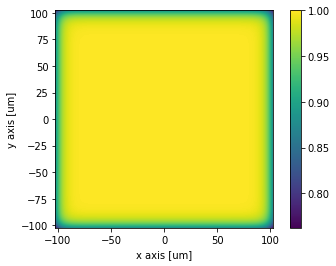

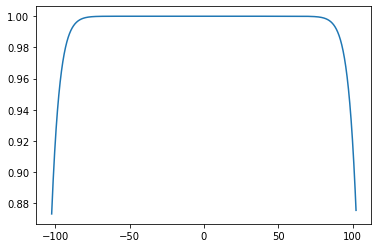

In [ ]:
# Below, factor defining whether we want a medium that is linear (nonlinearity = 0), focusing (n2 > 0, nonlinearity = 1)
# or defocusing (n2 < 0, nonlinearity = -1).
nonlinearity = 0   # Either -1 or 0 or 1 <---### EDIT HERE ###

# Variable that allows to switch between the paraxial (nonparaxial = 0) and nonparaxial (nonparaxial = 1) algorithm.
nonparaxial  = 0   # <---### EDIT HERE ###

# For the side boundaries, if our field gets there, it will appear from
# other side due to periodic boundary condition from FFT. To prevent that,
# we can either make the computation window bigger if we have room in terms
# of time and computation power OR we can apply absorbing boundaries by
# lowering the intensity towords boundaries. However we have to do it
# smoothly, otherwise numerical reflections will appear and results would
# be messed-up. To do that, we will multiply the field at every step with a
# rectangular super gaussian function that is mostly 1 but goes to 0 
# towards boundaries in a smooth manner. 
# IF YOU WANT TO HAVE absorbing boundaries, set absorbing_boundary=1 below, 
# otherwise set it to 0.
absorbing_boundary = 1
super_gaussian=cp.exp(-((X_ / (0.92*Lx_/(2*cp.sqrt(cp.log(2)))) )**20 + (Y_ / (0.92*Ly_/(2*cp.sqrt(cp.log(2)))) )**20))

super_gaussian_=super_gaussian.get()

plt.imshow(np.abs(super_gaussian_),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.show()

plt.plot(x_.get()*1e6,np.squeeze(np.abs(super_gaussian_[:,round(Ny/2)])))

#Definition of waveguide array

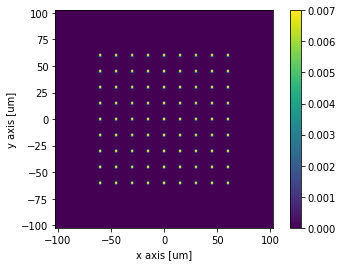

In [ ]:
wgds = cp.zeros((Nx,Ny))
width_x  = 2e-6                            
width_y  = 2.5e-6                          
seperation = 15e-6
wgd_num=int(120e-6/seperation+1)
delta_n = 0.007
for ii in range(wgd_num):
  for jj in range(wgd_num):
    ii_=ii-(wgd_num-1)/2
    jj_=jj-(wgd_num-1)/2
    wgds[cp.logical_and(cp.abs(X_-ii_*seperation)<=width_x/2,  cp.abs(Y_-jj_*seperation)<=width_y/2)]=1 
wgds= wgds*delta_n   
wgds_=wgds.get()
plt.imshow((wgds_),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.xlabel('x axis [um]')
plt.ylabel('y axis [um]')
plt.show()

sio.savemat('/content/drive/MyDrive/Giulia waveguides/Paper/Grids/grid'+str(seperation)+'.mat', {'grid':wgds_})


#Definition of the input field
Here, we define the complex input field either by generating here or loading from another file

In [ ]:
# load data from Google drive
filename = '/content/drive/MyDrive/Giulia waveguides/network/dataset/d_all_norm256.mat' # As an example, Newton.mat file is stored in a folder called "BPM lecture" in my drive
mat_contents = sio.loadmat(filename)
u_ = mat_contents['d_all_norm256']
print("data loaded...")
print(u_.shape)
# u is our input field

output_stack=np.array(np.zeros((1170,256,256)))

V=wgds

data loaded...
(1170, 256, 256)


#Propagation routine

Now we are ready to propagate

In [ ]:
t_start = time.time()

scale=( 140/204.8*Nx ) / 256
pad_pix=int(( Nx - ( 140/204.8*Nx ) )/2 )

for aa in range(1170): #Loop for propagating all the different input patterns
  
  print(aa)

  u_temp_=u_[aa,:,:]
  u_temp_sc_= interpolation.zoom(u_temp_,scale)
  u_temp_res_=np.pad(u_temp_sc_, ((pad_pix, pad_pix), (pad_pix, pad_pix)))
  u0=cp.asarray(u_temp_res_)

  count=0
  for index_z in range(Nz):
    count=count+1
    if nonparaxial == 0:
      # paraxial
      u1 = cp.fft.ifft2(cp.fft.fft2(u0) * cp.exp(-1j * K2 * 0.5 * dz))			# First linear half step
      u2 = u1 * cp.exp(1j * dz * (nonlinearity * cp.abs((u1))**2 + V))      # Nonlinear step
      u3 = cp.fft.ifft2(cp.fft.fft2(u2) * cp.exp(-1j * K2 * 0.5 * dz))			# Second linear step
    else:
      # Nonparaxial code
      u1 = cp.fft.ifft2(cp.fft.fft2(u0) * cp.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + cp.sqrt(k**2 - K2))))
      u2 = u1 * cp.exp(1j * dz * (nonlinearity * cp.abs(u1)**2 + V))
      u3 = cp.fft.ifft2(cp.fft.fft2(u2) * cp.exp(-1j * K2 * 0.5 * dz * scale_ratio / (k + cp.sqrt(k**2 - K2))))

    # Get ready for the next step
    if absorbing_boundary==1:
      u0 = u3*super_gaussian
    else:
      u0 = u3

  
  # Let's store the result in a variable with a more explicit name
  output = u3[pad_pix:Nx-pad_pix,pad_pix:Nx-pad_pix]
  output_down_temp=cp.abs(output)**2
  output_down=output_down_temp.get()
  output_downsampled= interpolation.zoom(output_down,1/scale)
  output_stack[aa,:,:]=output_downsampled
 

  # Intermediate savings in case of computer/program crash
  if aa==299: 
    sio.savemat('/content/drive/MyDrive/Giulia waveguides/Paper/outputs BPM/1cm/output_stack_1to300_'+str(seperation)+'.mat', {'output_stack1to300':output_stack})
  if aa==599:
    sio.savemat('/content/drive/MyDrive/Giulia waveguides/Paper/outputs BPM/1cm/output_stack_1to600_'+str(seperation)+'.mat', {'output_stack1to600':output_stack})
  if aa==899:
    sio.savemat('/content/drive/MyDrive/Giulia waveguides/Paper/outputs BPM/1cm/output_stack_600to900_'+str(seperation)+'.mat', {'output_stack600to900':output_stack})

 
sio.savemat('/content/drive/MyDrive/Giulia waveguides/Paper/outputs BPM/1cm/output_stack_All_'+str(seperation)+'.mat', {'output_stack_ALL':output_stack})

t_end = time.time()
print("time elapsed:",(t_end-t_start),"seconds")

900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119


#Display results

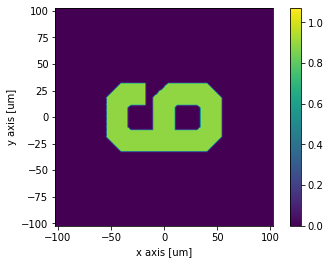

(256, 256)


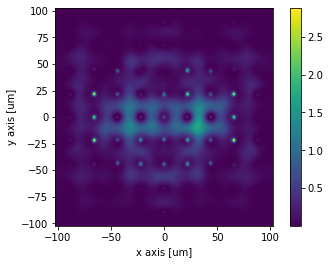

(2048, 2048)


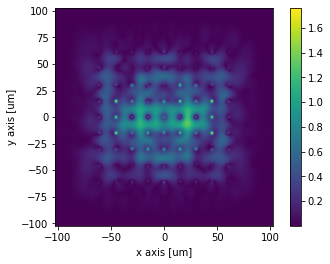

In [ ]:
u_=u_temp_res_

plt.imshow(np.abs(u_),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.show()

output_=output_downsampled
print(output_.shape)

plt.imshow(np.abs(output_),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.show()

u3_=u3.get()
print(u3_.shape)

plt.imshow(np.abs(u3_),extent=[-Lx_/2*1e6,Lx_/2*1e6,-Ly_/2*1e6,Ly_/2*1e6])
plt.colorbar()
plt.show()


